## Imports

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Hyperparameters

In [3]:
EPOCHS = 150
BATCH_SIZE = 128

IMG_HEIGHT = 256
IMG_WIDTH = 256

# Dataset directory
dataset_path = os.environ['DATASET_PATH']
directory_path = pathlib.Path(dataset_path)

## Loading the Dataset using Keras

In [4]:
# Create datasets from the images
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    # image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

datagen = ImageDataGenerator(
    rotation_range=20,  # randomly rotate images by 0 to 20 degrees
    width_shift_range=0.2,  # randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,  # randomly shift images vertically by 20% of the height
    shear_range=0.2,  # apply random shear transformation
    zoom_range=0.2,  # randomly zoom in on images by 20%
    horizontal_flip=True,  # randomly flip images horizontally
    fill_mode='nearest',  # strategy for filling in newly created pixels after transformations
    validation_split=0.2
)

# Create a training data generator for the augmented images
train_generator = datagen.flow_from_directory(
        directory_path,
        class_mode='binary',
        subset="training",
        seed=123,
        batch_size=BATCH_SIZE)

validation_generator = datagen.flow_from_directory(
        directory_path,
        class_mode='binary',
        subset="validation",
        seed=123,
        batch_size=BATCH_SIZE)


Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


## EDA (Exploratory Data Analysis)

In [5]:
# Prints the Total Number of Images in the Dataset
print(f'Number of Images: ', len(list(directory_path.glob('*/*.jpeg'))))

Number of Images:  24209


In [6]:
# Prints the classifications of Animals from the Dataset
class_names = train_generator.class_indices
class_names = list(class_names.keys())
print(class_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [7]:
# Prints the Number of Images in each Class
for class_name in class_names:
    print(f'Number of {class_name} Images: ', len(list(directory_path.glob(f'{class_name}/*.jpeg'))))

Number of butterfly Images:  1650
Number of cat Images:  1227
Number of chicken Images:  3098
Number of cow Images:  1866
Number of dog Images:  4863
Number of elephant Images:  1079
Number of horse Images:  2623
Number of sheep Images:  1444
Number of spider Images:  4497
Number of squirrel Images:  1862


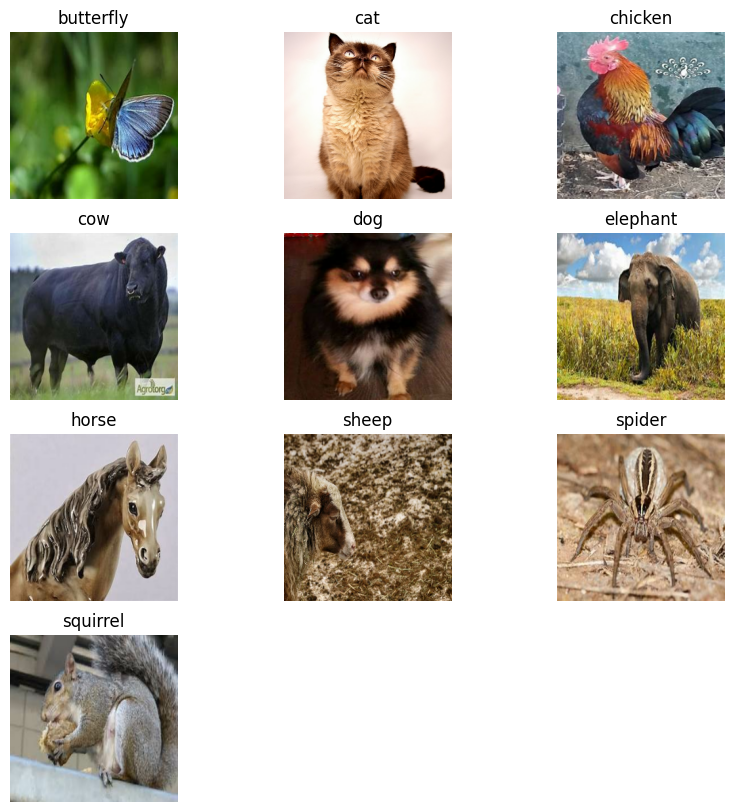

In [8]:
# Plots one image from each of the 10 classes
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(4, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

## Model

In [9]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 256, 256, 3)
(128,)


### Overfitting Prevention

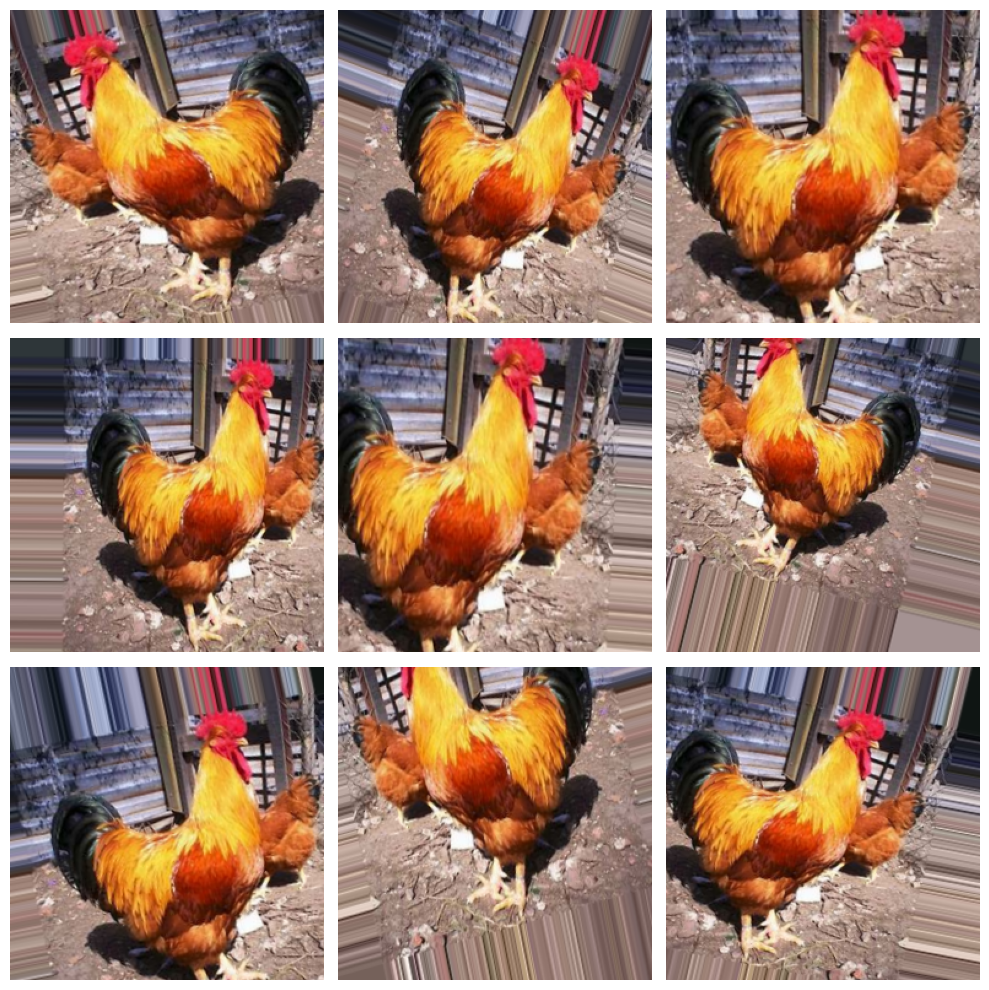

In [17]:
# Shows the Augmented Images
# Select a single image from the train_ds dataset
for image_batch, _ in train_ds.take(1):
    image = image_batch[0].numpy()  # Extract the first image from the batch

# Generate augmented versions of the image using datagen
augmented_images = []
for _ in range(9):
    augmented_images.append(datagen.random_transform(image))

# Create a 3 x 3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Display the augmented images
for i, ax in enumerate(axes.flatten()):
    ax.imshow(augmented_images[i].astype("uint8"))
    ax.axis("off")

plt.tight_layout()
plt.show()

### Creating the Model

In [19]:
num_classes = len(class_names)

# Add Dropout to the Model along with other layers
model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(256, (7, 7), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.2),
  layers.Flatten(),


  layers.Dense(256, activation='relu'),
  layers.Dense(50, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [20]:
# Compiles the Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        5

## Training

In [22]:
# Train the Model
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=EPOCHS,
  verbose=2
)

Epoch 1/150
164/164 - 433s - loss: 2.0826 - accuracy: 0.2598 - val_loss: 1.8647 - val_accuracy: 0.3639 - 433s/epoch - 3s/step
Epoch 2/150
164/164 - 290s - loss: 1.6446 - accuracy: 0.4361 - val_loss: 1.5085 - val_accuracy: 0.4815 - 290s/epoch - 2s/step
Epoch 3/150
164/164 - 230s - loss: 1.3912 - accuracy: 0.5217 - val_loss: 1.4506 - val_accuracy: 0.5046 - 230s/epoch - 1s/step
Epoch 4/150
164/164 - 174s - loss: 1.2475 - accuracy: 0.5717 - val_loss: 1.1809 - val_accuracy: 0.5898 - 174s/epoch - 1s/step
Epoch 5/150
164/164 - 173s - loss: 1.1446 - accuracy: 0.6041 - val_loss: 1.1215 - val_accuracy: 0.6181 - 173s/epoch - 1s/step
Epoch 6/150
164/164 - 173s - loss: 1.0648 - accuracy: 0.6367 - val_loss: 1.0580 - val_accuracy: 0.6388 - 173s/epoch - 1s/step
Epoch 7/150
164/164 - 174s - loss: 1.0047 - accuracy: 0.6543 - val_loss: 1.0264 - val_accuracy: 0.6458 - 174s/epoch - 1s/step
Epoch 8/150
164/164 - 175s - loss: 0.9529 - accuracy: 0.6741 - val_loss: 1.0446 - val_accuracy: 0.6462 - 175s/epoch - 

## Results

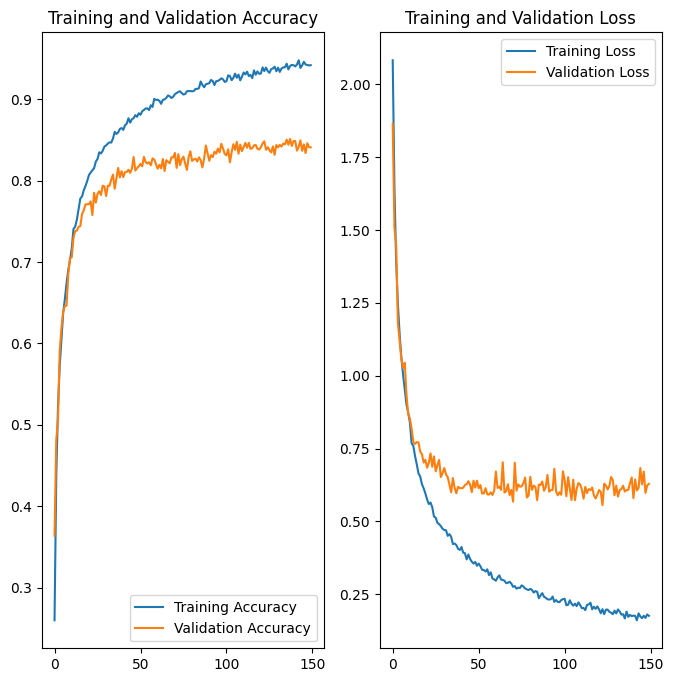

In [23]:
# Plot the Training and Validation Graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# Save the Model
model.save(os.path.join(os.environ['MODELS_PATH'], 'model.h5'))

In [25]:
# Take in an image and use the model to predict the class of the image
def predict_image(image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        f'This image most likely belongs to {class_names[np.argmax(score)]} with a {100 * np.max(score)} percent confidence.'
    )

    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 179ms/step
This image most likely belongs to cat with a 100.0 percent confidence.


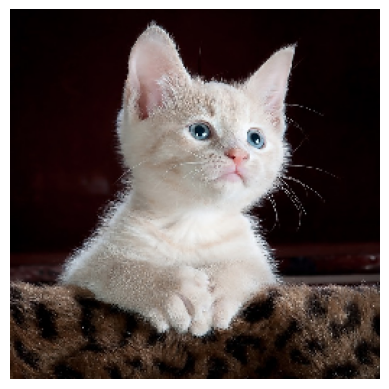

In [26]:
predict_image(os.path.join(os.environ['TEST_IMG_PATH'], 'cat.jpg'))